In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [143]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc3


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

**Get the data**

---


Read toefl data from project repositoy

In [148]:
df = pd.read_csv('https://raw.githubusercontent.com/xiaomeng-ma/AES-Project/master/TOEFL_11/processed_toefl.csv?token=AKHHIKHHXT4NNHAUAQFLBDS6V4QSI')
df.head()

,Prompt,Language,Score Level,total word,distance,Hpoint,xmin,alpha,mu,sigma,logtrue,file,pl_s,pl_C,pl_R2,log_d,log_m,log_k,log_R2
0,5,6,high,385,6.000000,8,2.0,2.273182,-10.388887,3.025490,0,88,0.626725,27.346485,0.883300,3.478245,0.639538,1.090635,0.869275
1,5,1,medium,321,11.000000,7,3.0,2.421178,-2.618379,1.817156,0,278,0.720874,31.641664,0.962596,3.573915,0.757765,1.032666,0.951214
2,0,9,high,363,8.306624,6,2.0,2.398038,-2.825649,1.739209,0,348,0.621470,21.737883,0.965709,3.352892,0.874682,0.849857,0.889519
3,1,10,medium,362,4.690416,6,5.0,3.410995,0.835672,0.746383,0,666,0.538645,18.320499,0.924139,2.824981,0.296708,1.441791,0.969115
4,5,8,medium,344,10.630146,7,6.0,3.124099,-0.359383,1.163868,0,733,0.646729,25.998149,0.938335,3.393319,0.638436,1.093227,0.926643


**Convert Target column to numberic**

In [149]:
score_mapping ={
    'low':0,
    'medium':1,
    'high': 2
}
inv_score_mapping = {v: k for k, v in score_mapping.items()}
df['Score Level'] = df['Score Level'].map(score_mapping)
df.head()

,Prompt,Language,Score Level,total word,distance,Hpoint,xmin,alpha,mu,sigma,logtrue,file,pl_s,pl_C,pl_R2,log_d,log_m,log_k,log_R2
0,5,6,2,385,6.000000,8,2.0,2.273182,-10.388887,3.025490,0,88,0.626725,27.346485,0.883300,3.478245,0.639538,1.090635,0.869275
1,5,1,1,321,11.000000,7,3.0,2.421178,-2.618379,1.817156,0,278,0.720874,31.641664,0.962596,3.573915,0.757765,1.032666,0.951214
2,0,9,2,363,8.306624,6,2.0,2.398038,-2.825649,1.739209,0,348,0.621470,21.737883,0.965709,3.352892,0.874682,0.849857,0.889519
3,1,10,1,362,4.690416,6,5.0,3.410995,0.835672,0.746383,0,666,0.538645,18.320499,0.924139,2.824981,0.296708,1.441791,0.969115
4,5,8,1,344,10.630146,7,6.0,3.124099,-0.359383,1.163868,0,733,0.646729,25.998149,0.938335,3.393319,0.638436,1.093227,0.926643


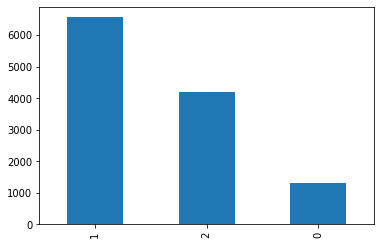

In [150]:
df['Score Level'].value_counts().plot(kind='bar')

**Divide variables into independent variables and a dependent variable**

In [0]:
X, y = df.drop(['Score Level'],axis=1), df['Score Level']

**Normalize the data using Standard Scaler**

In [0]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

**Divide the data into a test and training set**

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123,stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9678, 18) (9678,) (2420, 18) (2420,)


**Define a deep learning model**

In [0]:
model = keras.Sequential([
    layers.Dense(1000, activation='relu', input_shape=[X.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3)
  ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mae', 'mse'])



**Fit model with Train data with validation split 0.2**

In [159]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

history = model.fit(X_train, y_train, validation_split = 0.2,callbacks=[early_stop, tfdocs.modeling.EpochDots()], epochs=100)

Epoch 1/100
237/242 [============================>.] - ETA: 0s - loss: 0.8222 - accuracy: 0.6148 - mae: 1.8985 - mse: 5.1108
Epoch: 0, accuracy:0.6159,  loss:0.8210,  mae:1.8980,  mse:5.1095,  val_accuracy:0.6653,  val_loss:0.7047,  val_mae:1.8452,  val_mse:4.8620,  
242/242 [==============================] - 1s 4ms/step - loss: 0.8210 - accuracy: 0.6159 - mae: 1.8980 - mse: 5.1095 - val_loss: 0.7047 - val_accuracy: 0.6653 - val_mae: 1.8452 - val_mse: 4.8620
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7360 - accuracy: 0.6474 - mae: 2.1585 - mse: 6.9829 - val_loss: 0.6686 - val_accuracy: 0.6705 - val_mae: 2.2589 - val_mse: 7.8248
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7192 - accuracy: 0.6567 - mae: 2.3421 - mse: 8.6515 - val_loss: 0.6728 - val_accuracy: 0.6963 - val_mae: 2.3219 - val_mse: 7.9762
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7037 - accuracy: 0.6726 - mae: 2.4583 - mse: 9

Text(0, 0.5, 'accuracy')

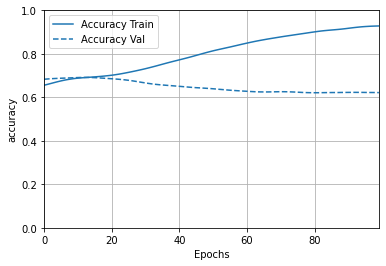

In [160]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Accuracy': history}, metric = "accuracy")
plt.ylim([0, 1])
plt.ylabel('accuracy')

In [163]:
loss, accuracy ,mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set loss: {:5.2f} , accuracy: {:5.2f}, mae: {:5.2f}, mse: {:5.2f}  ".format(loss, accuracy, mae, mse))

76/76 - 0s - loss: 2.9257 - accuracy: 0.6298 - mae: 12.2840 - mse: 644.5778
Testing set loss:  2.93 , accuracy:  0.63, mae: 12.28, mse: 644.58  


Code Reference 


1.   https://www.tensorflow.org/tutorials/keras/regression
2.   List item

